### 1. Import section & Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from decimal import Decimal
# PyTorch
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torch_geometric.data import Data, Batch
import torch.optim as optim
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import GINConv, global_add_pool, GCNConv, global_mean_pool
import torch_geometric
from torch.nn import Linear
from torch_geometric.nn import GCNConv, GATConv, GATv2Conv, TransformerConv
import torch.nn.functional as F


#Sklearn
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#Networkx
import networkx as nx



In [74]:
def calculate_node_features(graph):
    # Calcular las características de los nodos
    
    # Calcular el coeficiente de clustering para cada nodo
    clustering_coeffs = nx.clustering(graph)
    #Calcular el grado del nodo
    degree = nx.degree(graph)
    # Calcular Centralidad de intermediación
#    betweenness_centrality = nx.betweenness_centrality(graph)
#     # Calcular Centralidad de cercanía
#     closeness_centrality = nx.closeness_centrality(graph)
#     # Calular Centralidad de autovector
#     eigenvector_centrality = nx.eigenvector_centrality(graph)
#     #Calcular el PageRank para cada nodo
    pagerank = nx.pagerank(graph)

    # Obtener los nodos y sus características
    nodes = list(graph.nodes())
    x = torch.tensor([[clustering_coeffs[node], degree[node],#, betweenness_centrality[node],
                       #closeness_centrality[node], eigenvector_centrality[node],
                       pagerank[node]
                        #betweenness_centrality[node]
                      ] for node in nodes], dtype=torch.float)

    return x

In [35]:
def load_gpickle_files(path):
    X_path = os.path.join(path, "X")  # Ruta de la carpeta con los grafos
    y_path = os.path.join(path, "y")  # Ruta de la carpeta con las etiquetas

    file_list = os.listdir(X_path)  # Obtén la lista de archivos gpickle
    dataset = []

    for file in file_list:
        file_path = os.path.join(X_path, file)  # Genera la ruta del archivo
        graph = nx.read_gpickle(file_path)  # Lee el archivo gpickle con NetworkX

        # Calcular las características de los nodos
        x = calculate_node_features(graph)
        # Obtiene la matriz dispersa de adyacencia
        adj_matrix = nx.convert_matrix.to_scipy_sparse_matrix(graph)

        # Convierte la matriz dispersa en un tensor de PyTorch
        edge_index = torch.from_numpy(np.vstack(adj_matrix.nonzero()))
#         edge_index = torch.tensor(list(graph.edges()), dtype=torch.long).t().contiguous()  # Índices de las aristas
#         adj_matrix = nx.adjacency_matrix(graph)
#         adj_matrix = adj_matrix.toarray()

        file_number = os.path.splitext(file)[0]
        with open(os.path.join(y_path, f"{file_number}.txt")) as f:
            target = f.read()
            y = torch.tensor(np.float_(target), dtype=torch.float)

        data = Data(x=x, edge_index=edge_index, y=y)  # Crea un objeto Data
        dataset.append(data)

    return dataset

def custom_collate(batch):
    # Extraer los elementos del lote y crear listas separadas para cada atributo
    x_list = []
    edge_index_list = []
    y_list = []

    for data in batch:
        x_list.append(data.x)
        edge_index_list.append(data.edge_index)
        y_list.append(data.y)

    # Convertir las listas en arreglos de numpy
    x_batch = np.stack(x_list)
    edge_index_batch = np.stack(edge_index_list)
    y_batch = np.stack(y_list)

    return Data(x=x_batch, edge_index=edge_index_batch, y=y_batch)


In [36]:
import matplotlib.pyplot as plt

def plot_learning_curves(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(8, 6))

    # Plot losses
    plt.plot(epochs, train_losses, label='Train')
    plt.plot(epochs, val_losses, label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Curva de Aprendizaje')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [37]:
def train(model, num_epochs, dataset, data_test):
    
    #model3=GNN(input_size=3, hidden_channels=3)
    learning_rate = 0.001
    # Definir la función de pérdida y el optimizador
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Listas para almacenar las pérdidas en cada época
    train_losses = []
    val_losses = []

    #num_epochs = 12
    model.train()  # Cambiar al modo de entrenamiento

    for epoch in range(num_epochs):
        running_loss = 0.0

        for data in dataset:
            x = data.x  # Características de los nodos
            edge_index = data.edge_index
            y = data.y#.view(-1)#.to(device)  # Etiquetas o clases

            optimizer.zero_grad()
            logits = model(x=x, edge_index=edge_index)
            loss = loss_fn(logits, y)
            loss.backward()  # Realizar el paso de atrás (backward)
            optimizer.step()  # Actualizar los pesos del modelo

            running_loss += loss.item()

        # Calcular la pérdida promedio en cada época
        epoch_loss = running_loss / len(dataset)
        train_losses.append(epoch_loss)

        # Realizar la validación del modelo en cada época
        model.eval()  # Cambiar al modo de evaluación

        with torch.no_grad():
            running_val_loss = 0.0

            for data in data_test:
                x_val = data.x
                edge_index_val = data.edge_index
                y_val = data.y#.view(-1)#.to(device)

                val_logits = model(x=x_val, edge_index=edge_index_val)
                val_loss = loss_fn(val_logits, y_val)

                running_val_loss += val_loss.item()

            # Calcular la pérdida promedio en la validación
            val_epoch_loss = running_val_loss / len(data_test)
            val_losses.append(val_epoch_loss)

        # Imprimir información del progreso del entrenamiento
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_epoch_loss:.4f}')

    # Crear las curvas de aprendizaje
    plot_learning_curves(train_losses, val_losses)

In [6]:
def testing(model, dataset):
    model.eval()  # Set the model in evaluation mode
    total_samples = 0
    total_loss = 0
    predictions_list = []
    labels_list = []

    learning_rate = 0.001
    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    with torch.no_grad():
        for data in dataset:
            x = data.x  # Características de los nodo
            edge_index = data.edge_index
            y = data.y.unsqueeze(0)#.view(-1)#.to(device)  # Etiquetas o clases


            predictions = model(x=x, edge_index=edge_index)  # Forward pass

            loss = loss_fn(predictions, y)
            total_loss += loss.item()

            predictions_list.append(predictions.detach().cpu().numpy())
            labels_list.append(y.detach().cpu().numpy())

        # Calculate accuracy
        predictions_array = np.concatenate(predictions_list, axis=0)
        labels_array = np.concatenate(labels_list, axis=0)
        # Calculate MSE
        mse = mean_squared_error(labels_array, predictions_array)

        # Calculate MAE
        mae = mean_absolute_error(labels_array, predictions_array)

        # Calculate RMSE
        rmse = mean_squared_error(labels_array, predictions_array, squared=False)

        # Calculate R-squared
        r2 = r2_score(labels_array, predictions_array)

        print("MSE:", mse)
        print("MAE:", mae)
        print("RMSE:", rmse)
        print("R-squared:", r2)

        #print("Accuracy: {:.4f}".format(accuracy))
        # print("Mean Squared Error (MSE): {:.4f}".format(mse))
        # print("R-squared (R²): {:.4f}".format(r2))
        fig, ax = plt.subplots()
        ax.scatter(labels_array, predictions_array)
        ax.axline((0, 0), slope=1, color='red')
        # Add labels and title
        plt.xlabel("Labels")
        plt.ylabel("Predictions")
        plt.title("Predictions vs. Labels")
        

        # Display the plot
        plt.show()

### 2.Data

#### Training data

In [75]:
training = load_gpickle_files(r"C:\Users\l.sanchezparra\Documents\Personal\TFG\Python code\Dataset\500\Train")  # Carga los datos con la función load_gpickle_files

#### Validation data

In [76]:
validation = load_gpickle_files(r"C:\Users\l.sanchezparra\Documents\Personal\TFG\Python code\Dataset\500\Validation")  # Carga los datos con la función load_gpickle_files

#### Test data

In [77]:
test = load_gpickle_files(r"C:\Users\l.sanchezparra\Documents\Personal\TFG\Python code\Dataset\500\Test")  # Carga los datos con la función load_gpickle_files

### 3. Models

#### 3.1 One GCN Layer

In [78]:
class OneGCNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_channels):
        super(OneGCNLayer, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GCNConv(input_size, hidden_channels)
        
        
        self.lin = Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index, batch = None,  edge_col = None):
        
        # Node embedding 
        x = self.conv1(x, edge_index, edge_col)
               
        # Readout layer
        batch = torch.zeros(x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)
        
        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Train Loss: 0.4078, Val Loss: 0.0810
Epoch [2/20], Train Loss: 0.0827, Val Loss: 0.0797
Epoch [3/20], Train Loss: 0.0820, Val Loss: 0.0786
Epoch [4/20], Train Loss: 0.0806, Val Loss: 0.0769
Epoch [5/20], Train Loss: 0.0784, Val Loss: 0.0745
Epoch [6/20], Train Loss: 0.0756, Val Loss: 0.0715
Epoch [7/20], Train Loss: 0.0722, Val Loss: 0.0678
Epoch [8/20], Train Loss: 0.0682, Val Loss: 0.0637
Epoch [9/20], Train Loss: 0.0635, Val Loss: 0.0597
Epoch [10/20], Train Loss: 0.0583, Val Loss: 0.0570
Epoch [11/20], Train Loss: 0.0535, Val Loss: 0.0554
Epoch [12/20], Train Loss: 0.0501, Val Loss: 0.0540
Epoch [13/20], Train Loss: 0.0481, Val Loss: 0.0528
Epoch [14/20], Train Loss: 0.0469, Val Loss: 0.0519
Epoch [15/20], Train Loss: 0.0461, Val Loss: 0.0511
Epoch [16/20], Train Loss: 0.0455, Val Loss: 0.0505
Epoch [17/20], Train Loss: 0.0451, Val Loss: 0.0500
Epoch [18/20], Train Loss: 0.0447, Val Loss: 0.0495
Epoch [19/20], Train Loss: 0.0444, Val Loss: 0.0492
Epoch [20/20], Train 

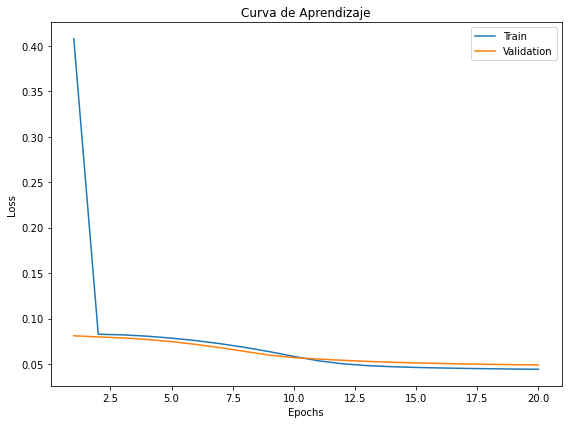

In [79]:
model1=OneGCNLayer(input_size=3, hidden_channels=3)
train(model1,20, training, validation)

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 0.056816142
MAE: 0.19666506
RMSE: 0.23836137
R-squared: 0.3185008457776597


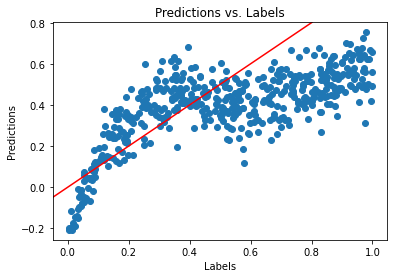

In [80]:
testing(model1, test)

#### 3.2 Two GCN Layers

In [81]:
class TwoGCNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_channels):
        super(TwoGCNLayer, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GCNConv(input_size, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        
        self.lin = Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index, batch = None,  edge_col = None):
        
        # Node embedding 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        
        # Readout layer
        batch = torch.zeros(x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)
        
        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Train Loss: 0.1983, Val Loss: 0.0810
Epoch [2/20], Train Loss: 0.0826, Val Loss: 0.0805
Epoch [3/20], Train Loss: 0.0826, Val Loss: 0.0803
Epoch [4/20], Train Loss: 0.0825, Val Loss: 0.0802
Epoch [5/20], Train Loss: 0.0823, Val Loss: 0.0801
Epoch [6/20], Train Loss: 0.0822, Val Loss: 0.0800
Epoch [7/20], Train Loss: 0.0821, Val Loss: 0.0799
Epoch [8/20], Train Loss: 0.0819, Val Loss: 0.0798
Epoch [9/20], Train Loss: 0.0818, Val Loss: 0.0797
Epoch [10/20], Train Loss: 0.0817, Val Loss: 0.0795
Epoch [11/20], Train Loss: 0.0815, Val Loss: 0.0794
Epoch [12/20], Train Loss: 0.0813, Val Loss: 0.0791
Epoch [13/20], Train Loss: 0.0811, Val Loss: 0.0788
Epoch [14/20], Train Loss: 0.0808, Val Loss: 0.0784
Epoch [15/20], Train Loss: 0.0804, Val Loss: 0.0779
Epoch [16/20], Train Loss: 0.0798, Val Loss: 0.0772
Epoch [17/20], Train Loss: 0.0791, Val Loss: 0.0763
Epoch [18/20], Train Loss: 0.0781, Val Loss: 0.0751
Epoch [19/20], Train Loss: 0.0769, Val Loss: 0.0735
Epoch [20/20], Train 

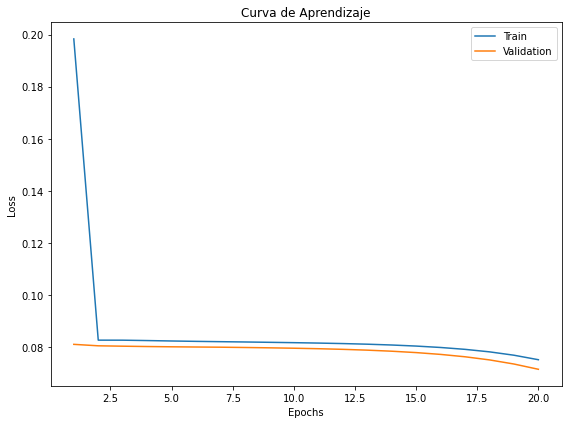

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 0.076325595
MAE: 0.23700769
RMSE: 0.27627087
R-squared: 0.08448852236910431


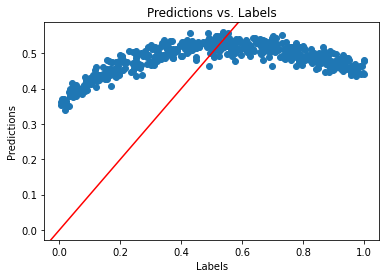

In [82]:
model2=TwoGCNLayer(input_size=3, hidden_channels=3)
train(model2, 20, training, validation)
testing(model2, test)

#### 3.3 Three GCN Layers

In [65]:
class ThreeGCNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_channels):
        super(ThreeGCNLayer, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GCNConv(input_size, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        
        self.lin = Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index, batch = None,  edge_col = None):
        
        # Node embedding 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_col)
               
        # Readout layer
        batch = torch.zeros(x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)
        
        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Train Loss: 0.0896, Val Loss: 0.0811
Epoch [2/20], Train Loss: 0.0826, Val Loss: 0.0807
Epoch [3/20], Train Loss: 0.0822, Val Loss: 0.0804
Epoch [4/20], Train Loss: 0.0819, Val Loss: 0.0801
Epoch [5/20], Train Loss: 0.0816, Val Loss: 0.0793
Epoch [6/20], Train Loss: 0.0804, Val Loss: 0.0772
Epoch [7/20], Train Loss: 0.0776, Val Loss: 0.0731
Epoch [8/20], Train Loss: 0.0719, Val Loss: 0.0653
Epoch [9/20], Train Loss: 0.0558, Val Loss: 0.0438
Epoch [10/20], Train Loss: 0.0356, Val Loss: 0.0281
Epoch [11/20], Train Loss: 0.0247, Val Loss: 0.0215
Epoch [12/20], Train Loss: 0.0208, Val Loss: 0.0187
Epoch [13/20], Train Loss: 0.0188, Val Loss: 0.0168
Epoch [14/20], Train Loss: 0.0172, Val Loss: 0.0152
Epoch [15/20], Train Loss: 0.0159, Val Loss: 0.0139
Epoch [16/20], Train Loss: 0.0148, Val Loss: 0.0128
Epoch [17/20], Train Loss: 0.0140, Val Loss: 0.0119
Epoch [18/20], Train Loss: 0.0133, Val Loss: 0.0113
Epoch [19/20], Train Loss: 0.0128, Val Loss: 0.0108
Epoch [20/20], Train 

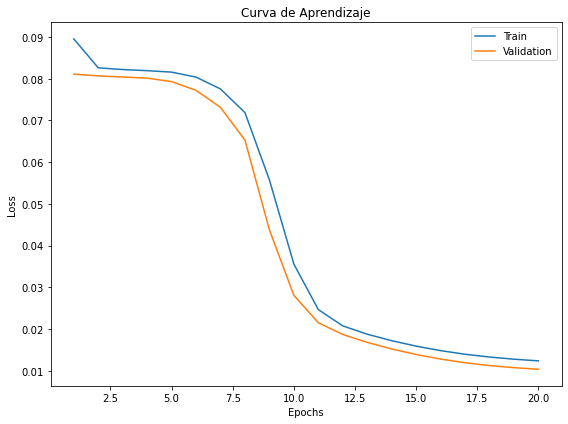

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 0.0118237
MAE: 0.0869549
RMSE: 0.108736835
R-squared: 0.8581768951197442


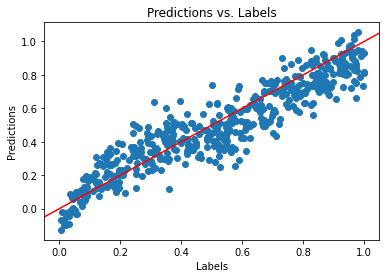

In [83]:
model3=ThreeGCNLayer(input_size=3, hidden_channels=3)
train(model3, 20, training, validation)
testing(model3, test)

#### 3.4 FourGCN Layers

In [69]:
class FourGCNLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_channels):
        super(FourGCNLayer, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GCNConv(input_size, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        
        
        self.lin = Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index, batch = None,  edge_col = None):
        
        # Node embedding 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_col)
               
        # Readout layer
        batch = torch.zeros(x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)
        
        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Train Loss: 0.0823, Val Loss: 0.0804
Epoch [2/30], Train Loss: 0.0820, Val Loss: 0.0804
Epoch [3/30], Train Loss: 0.0820, Val Loss: 0.0804
Epoch [4/30], Train Loss: 0.0820, Val Loss: 0.0804
Epoch [5/30], Train Loss: 0.0820, Val Loss: 0.0804
Epoch [6/30], Train Loss: 0.0820, Val Loss: 0.0804
Epoch [7/30], Train Loss: 0.0820, Val Loss: 0.0804
Epoch [8/30], Train Loss: 0.0820, Val Loss: 0.0804
Epoch [9/30], Train Loss: 0.0820, Val Loss: 0.0804
Epoch [10/30], Train Loss: 0.0819, Val Loss: 0.0804
Epoch [11/30], Train Loss: 0.0819, Val Loss: 0.0803
Epoch [12/30], Train Loss: 0.0818, Val Loss: 0.0799
Epoch [13/30], Train Loss: 0.0815, Val Loss: 0.0792
Epoch [14/30], Train Loss: 0.0807, Val Loss: 0.0779
Epoch [15/30], Train Loss: 0.0792, Val Loss: 0.0758
Epoch [16/30], Train Loss: 0.0767, Val Loss: 0.0726
Epoch [17/30], Train Loss: 0.0728, Val Loss: 0.0680
Epoch [18/30], Train Loss: 0.0630, Val Loss: 0.0521
Epoch [19/30], Train Loss: 0.0419, Val Loss: 0.0292
Epoch [20/30], Train 

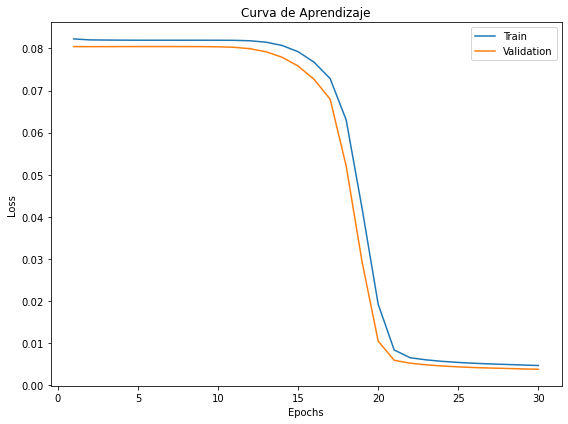

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 0.0038020725
MAE: 0.050133362
RMSE: 0.06166095
R-squared: 0.954394844755825


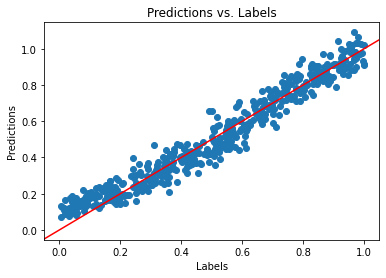

In [85]:
model4=FourGCNLayer(input_size=3, hidden_channels=3)
train(model4, 30, training, validation)
testing(model4, test)

In [86]:
class FourGATLayer(torch.nn.Module):
    def __init__(self, input_size, hidden_channels):
        super(FourGATLayer, self).__init__()
        torch.manual_seed(12345)
        
        self.conv1 = GATConv(input_size, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, hidden_channels)
        self.conv4 = GATConv(hidden_channels, hidden_channels)
        
        
        self.lin = Linear(hidden_channels, 1)
    
    def forward(self, x, edge_index, batch = None,  edge_col = None):
        
        # Node embedding 
        x = self.conv1(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv2(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv3(x, edge_index, edge_col)
        x = x.relu()
        x = self.conv4(x, edge_index, edge_col)
               
        # Readout layer
        batch = torch.zeros(x.shape[0],dtype=int) if batch is None else batch
        x = global_mean_pool(x, batch)
        
        # Final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
    
        return x

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/20], Train Loss: 0.0645, Val Loss: 0.0185
Epoch [2/20], Train Loss: 0.0063, Val Loss: 0.0071
Epoch [3/20], Train Loss: 0.0042, Val Loss: 0.0073
Epoch [4/20], Train Loss: 0.0037, Val Loss: 0.0076
Epoch [5/20], Train Loss: 0.0035, Val Loss: 0.0076
Epoch [6/20], Train Loss: 0.0034, Val Loss: 0.0073
Epoch [7/20], Train Loss: 0.0032, Val Loss: 0.0063
Epoch [8/20], Train Loss: 0.0030, Val Loss: 0.0063
Epoch [9/20], Train Loss: 0.0029, Val Loss: 0.0061
Epoch [10/20], Train Loss: 0.0028, Val Loss: 0.0059
Epoch [11/20], Train Loss: 0.0027, Val Loss: 0.0053
Epoch [12/20], Train Loss: 0.0027, Val Loss: 0.0050
Epoch [13/20], Train Loss: 0.0026, Val Loss: 0.0047
Epoch [14/20], Train Loss: 0.0026, Val Loss: 0.0045
Epoch [15/20], Train Loss: 0.0026, Val Loss: 0.0040
Epoch [16/20], Train Loss: 0.0025, Val Loss: 0.0039
Epoch [17/20], Train Loss: 0.0025, Val Loss: 0.0035
Epoch [18/20], Train Loss: 0.0024, Val Loss: 0.0031
Epoch [19/20], Train Loss: 0.0024, Val Loss: 0.0029
Epoch [20/20], Train 

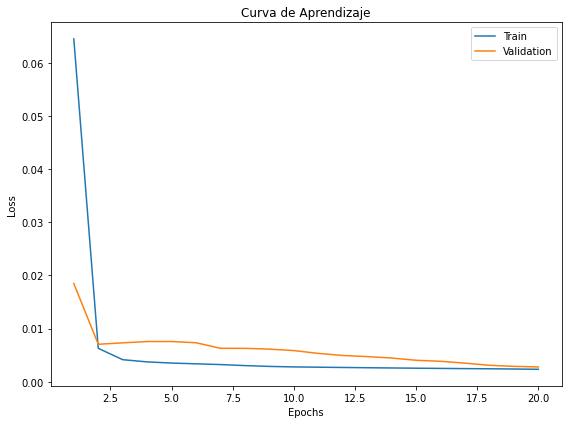

C:\Users\l.sanchezparra\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


MSE: 0.0026983467
MAE: 0.042069748
RMSE: 0.05194561
R-squared: 0.9676338272294175


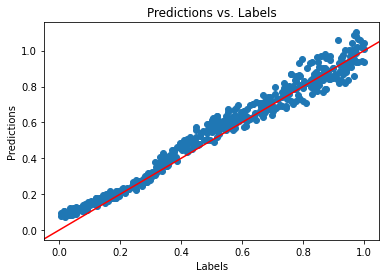

In [87]:
model4=FourGATLayer(input_size=3, hidden_channels=3)
train(model4, 20, training, validation)
testing(model4, test)